# 1. Setup and Load Data

## 1.1 Install Dependencies and Setup

In [ ]:
%pip install tensorflow opencv-python matplotlib

In [5]:
import tensorflow as tf
import os

## 1.2 Remove Dodgy Images

In [33]:
import cv2
import imghdr

In [23]:
data_dir = 'data'

In [ ]:
os.listdir(os.path.join(data_dir, 'happy'))

In [30]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [31]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

## 1.3 Load Data

In [34]:
import numpy as np
from matplotlib import pyplot as plt

In [78]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 178 files belonging to 2 classes.


In [79]:
data_iterator = data.as_numpy_iterator()

In [80]:
# Get batches from the iterator
batch = data_iterator.next()

In [81]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [82]:
# Class 0 == Happy
# Class 1 == Sad
batch[1]

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0], dtype=int32)

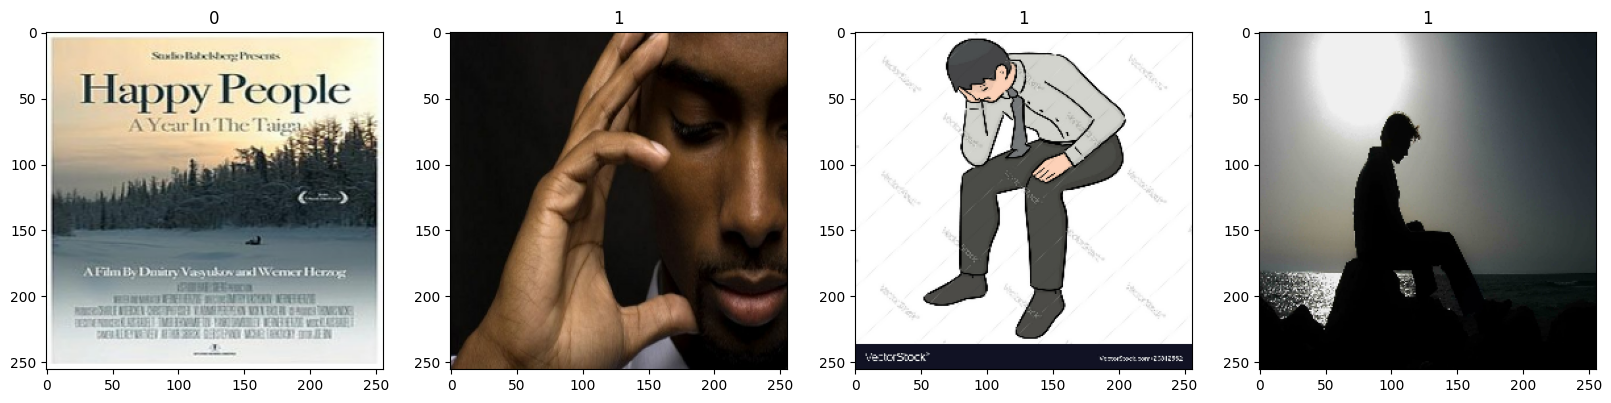

In [83]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 2. Preprocess Data

## 2.1 Scale Data

In [84]:
scaled = data.map(lambda x,y: (x/255, y))

In [85]:
scaled_iterator = scaled.as_numpy_iterator()

In [86]:
batch = scaled_iterator.next()

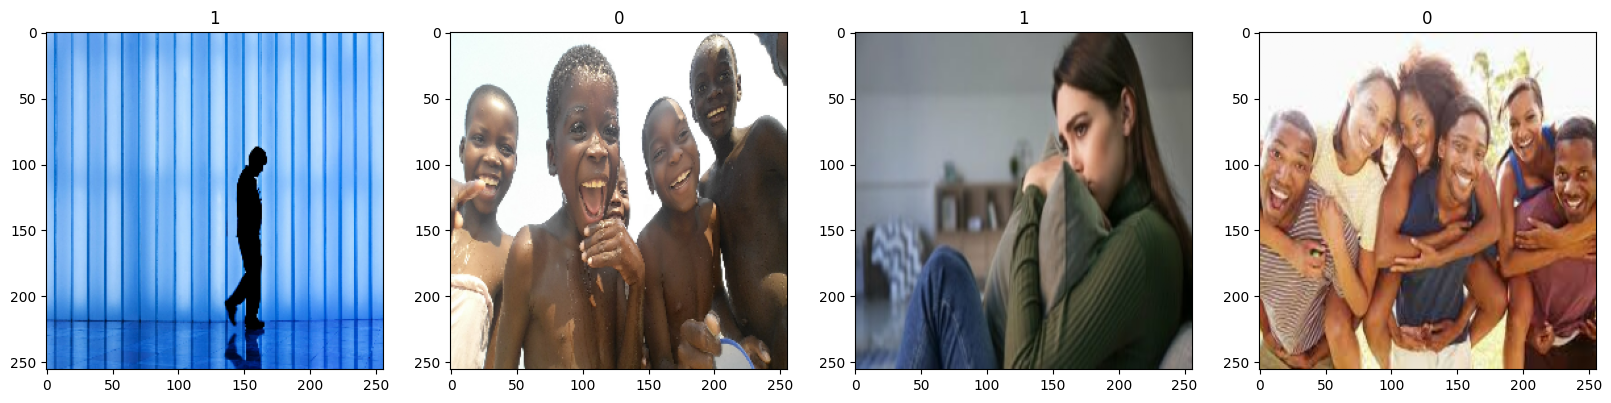

In [87]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## 2.2 Split Data

In [88]:
len(data)

6

In [89]:
# Training
# training set: 60%
train_size = int(len(data)*0.6)
# validation set: 20%
val_size = int(len(data)*0.2) + 1

# Post Training
# test size: 10%
test_size = int(len(data)*0.1) + 1

In [90]:
train_size + val_size + test_size

6

In [91]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [92]:
len(test)

1

# 3. Deep Model

## 3.1 Build Deep Learning Model

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [95]:
model = Sequential()

In [96]:
# Add a convolutional layer and a max pooling layer
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
# Condense
model.add(MaxPooling2D())


model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
# single output: sigmoid maps to a range between 0 and 1
model.add(Dense(1, activation='sigmoid'))

In [97]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

## 3.2 Train

In [99]:
logdir = 'logs'

In [100]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

## 3.3 Plot Performance

In [ ]:
hist.history

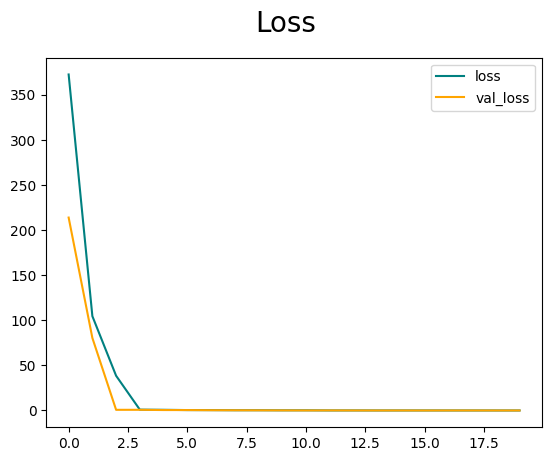

In [105]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

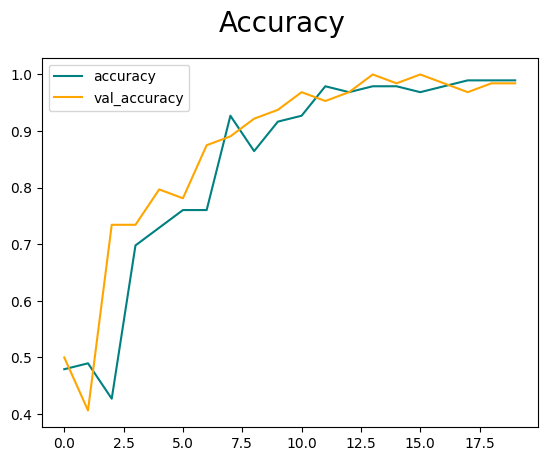

In [106]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()